# AML Week 2, Lecture 2: Sequence Models

## Learning Objectives

- How to build, fit, and evaluat sequence models (SimpleRNN, LSTM, GRU, Bidrectional)
- How to use Global Average Pooling + return_sequences=True
- How to use pre-trained word embeddings for modeling.


In [1]:
import tensorflow as tf
import numpy as np
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

# MacOS Sonoma Fix
tf.config.set_visible_devices([], 'GPU')

In [2]:
# Adding parent directory to python path
import os, sys
sys.path.append(os.path.abspath("../"))

In [3]:
## Load the autoreload extension
%load_ext autoreload 
%autoreload 2

import custom_functions  as fn
# fn.

## Data

In [4]:
from IPython.display import display, Markdown
with open("../Data-AmazonReviews/Amazon Product Reviews.md") as f:
    display(Markdown(f.read()))

# Amazon Product Reviews

- URL: https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews 

## Description

This is a large crawl of product reviews from Amazon. This dataset contains 82.83 million unique reviews, from around 20 million users.

## Basic statistics

| Ratings:  | 82.83 million        |
| --------- | -------------------- |
| Users:    | 20.98 million        |
| Items:    | 9.35 million         |
| Timespan: | May 1996 - July 2014 |

## Metadata

- reviews and ratings
- item-to-item relationships (e.g. "people who bought X also bought Y")
- timestamps
- helpfulness votes
- product image (and CNN features)
- price
- category
- salesRank

## Example

```
{  "reviewerID": "A2SUAM1J3GNN3B",  "asin": "0000013714",  "reviewerName": "J. McDonald",  "helpful": [2, 3],  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",  "overall": 5.0,  "summary": "Heavenly Highway Hymns",  "unixReviewTime": 1252800000,  "reviewTime": "09 13, 2009" }
```

## Download link

See the [Amazon Dataset Page](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/) for download information.

The 2014 version of this dataset is [also available](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon/links.html).

## Citation

Please cite the following if you use the data:

**Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering**

R. He, J. McAuley

*WWW*, 2016
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/www16a.pdf)

**Image-based recommendations on styles and substitutes**

J. McAuley, C. Targett, J. Shi, A. van den Hengel

*SIGIR*, 2015
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir15.pdf)

In [5]:
import pandas as pd 
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)

# Define a function for building an LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers

In [6]:
import joblib
df = joblib.load('../Data-AmazonReviews/processed_data.joblib')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8191 entries, 0 to 8256
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   overall            8191 non-null   float64
 1   text-raw           8191 non-null   object 
 2   length             8191 non-null   int64  
 3   text               8191 non-null   object 
 4   lower_text         8191 non-null   object 
 5   tokens             8191 non-null   object 
 6   no_stops           8191 non-null   object 
 7   no_stops_no_punct  8191 non-null   object 
 8   spacy_lemmas       8191 non-null   object 
 9   bigrams            8191 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 703.9+ KB


,overall,text-raw,length,text,lower_text,tokens,no_stops,no_stops_no_punct,spacy_lemmas,bigrams
0,4.0,Not going to show you the dirty water on here because I have shame and it ...: Used it twice already and I have absolutely seen results. Not going to show you the dirty water on here because I have shame and it is gross. I will say that while you...,672,Not going to show you the dirty water on here because I have shame and it ...: Used it twice already and I have absolutely seen results. Not going to show you the dirty water on here because I have shame and it is gross. I will say that while you...,not going to show you the dirty water on here because i have shame and it ...: used it twice already and i have absolutely seen results. not going to show you the dirty water on here because i have shame and it is gross. i will say that while you...,"[not, going, to, show, you, the, dirty, water, on, here, because, i, have, shame, and, it, ..., :, used, it, twice, already, and, i, have, absolutely, seen, results, ., not, going, to, show, you, the, dirty, water, on, here, because, i, have, sha...","[going, show, dirty, water, shame, ..., :, used, twice, already, absolutely, seen, results, ., going, show, dirty, water, shame, gross, ., say, 're, cleaning, ,, leave, place, second, (, instance, ,, 're, moving, plug, new, outlet, ), ,, leak, li...","[going, show, dirty, water, shame, ..., used, twice, already, absolutely, seen, results, going, show, dirty, water, shame, gross, say, 're, cleaning, leave, place, second, instance, 're, moving, plug, new, outlet, leak, little, water, part, sucks...","[go, dirty, water, shame, twice, absolutely, see, result, go, dirty, water, shame, gross, clean, leave, place, second, instance, move, plug, new, outlet, leak, little, water, suck, upward, big, deal, suck, right, happen, end, cleaning, remove, ta...","[(go, dirty), (dirty, water), (water, shame), (shame, twice), (twice, absolutely), (absolutely, see), (see, result), (result, go), (go, dirty), (dirty, water), (water, shame), (shame, gross), (gross, clean), (clean, leave), (leave, place), (place..."
1,5.0,Makes carpet look brand new!!!: When you get the shampooer you have to put it together but is very easy...the handle is the only thing that you have to attach...\n\n My carpets were very dirty because I have 2 small dogs that go in and hour all d...,1021,Makes carpet look brand new!!!: When you get the shampooer you have to put it together but is very easy...the handle is the only thing that you have to attach...\n\n My carpets were very dirty because I have 2 small dogs that go in and hour all d...,makes carpet look brand new!!!: when you get the shampooer you have to put it together but is very easy...the handle is the only thing that you have to attach...\n\n my carpets were very dirty because i have 2 small dogs that go in and hour all d...,"[makes, carpet, look, brand, new, !, !, !, :, when, you, get, the, shampooer, you, have, to, put, it, together, but, is, very, easy, ..., the, handle, is, the, only, thing, that, you, have, to, attach, ..., my, carpets, were, very, dirty, because...","[makes, carpet, look, brand, new, !, !, !, :, get, shampooer, put, together, easy, ..., handle, thing, attach, ..., carpets, dirty, 2, small, dogs, go, hour, day, ..., 1st, day, got, shampoo, shampooed, entire, house, made, huge, difference, ., w...","[makes, carpet, look, brand, new, get, shampooer, put, together, easy, ..., handle, thing, attach, ..., carpets, dirty, 2, small, dogs, go, hour, day, ..., 1st, day, got, shampoo, shampooed, entire, house, made, huge, difference, week, later, dow...","[make, carpet, look, brand, new, shampooer, easy, handle, thing, attach, carpet, dirty, 2, small, dog, hour, day, 1st, day, get, shampoo, shampoo, entire, house, huge, difference, week, later, downstair, dirt, carpet, shampoo, carpet, look, brian...","[(make, carpet), (carpet, look), (look, brand), (brand, new), (new, shampooer), (shampooer, easy), (easy, handle),

In [7]:
def create_groups(x):
    if x>=5.0:
        return "high"
    elif x <=2.0:
        return "low"
    else: 
        return None

To understand what customers do and do not like about Hoover products, we will define 2 groups:
- High Ratings
    - Overall rating = 5.0
- Low Ratings
    - Overall rating = 1.0 or 2.0


We can use a function and .map to define group names based on the numeric overall ratings.

In [8]:
## Use the function to create a new "rating" column with groups
df['rating'] = df['overall'].map(create_groups)
df['rating'].value_counts(dropna=False)

high    5547
None    1832
low      812
Name: rating, dtype: int64

In [9]:
## Check class balance of 'rating'
df['rating'].value_counts(normalize=True)

high    0.872307
low     0.127693
Name: rating, dtype: float64

In [10]:
# Create a df_ml without null ratings
df_ml = df.dropna(subset=['rating']).copy()
df_ml.isna().sum()

overall              0
text-raw             0
length               0
text                 0
lower_text           0
tokens               0
no_stops             0
no_stops_no_punct    0
spacy_lemmas         0
bigrams              0
rating               0
dtype: int64

In [11]:
## X - Option A)  lemmas
# def join_tokens(token_list):
#     joined_tokens = ' '.join(token_list)
#     return joined_tokens
# X = df_ml['spacy_lemmas'].apply(join_tokens)

# X - Option B) original raw text
X = df_ml['text']

# y - use our binary target 
y = df_ml['rating']
X.head(10)

1     Makes carpet look brand new!!!: When you get the shampooer you have to put it together but is very easy...the handle is the only thing that you have to attach...\n\n My carpets were very dirty because I have 2 small dogs that go in and hour all d...
4     VERY DISAPPOINTED: WORKED for maybe 1/2 hr and then it appeared the motor got hot and shut off and 10 secs later would start again and would work for 10 or 15 secs and quit again.......sending it back to HOOVER this week......I was VERY DISAPPOIN...
5                                                                 Perfect!: I love this cleaner!  It's easy to operate, light enough to manipulate and easy to clean. The tank holds plenty of shampoo and water solution and the suction for removal is great.
6     Wow - way exceeded expectations: I had the older model from probably 2001 and it was great for the occasional pet stain or the muddy paw prints on white carpet situation, but it was not for routine cleaning.  It finally konked

In [12]:
y.value_counts(normalize=True)

high    0.872307
low     0.127693
Name: rating, dtype: float64

## From Train-Test Split for ML to Train-Test-Val Split for ANNs

- Starting with a simple train-test-split for ML model (like in movie nlp project)
- Resampling Imbalanced training data
- Creating tensorflow dataset from X_train, y_train (so dataset is rebalanced)
- Creating tensorflow dataset (intended to be split in 2 ) for X_test and y_test

In [13]:
# Perform 70:30 train test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=.3, random_state=42)
len(X_train_full), len(X_test)

(4451, 1908)

### Using Sklearn's LabelEncoder

- Can't use text labels with neural networks.

In [14]:
y_train_full[:10]

3889    high
3254    high
2996    high
3790    high
3764    high
7301    high
2449    high
430     high
2296    high
2321     low
Name: rating, dtype: object

In [15]:
# Instansiate label encoder
encoder = LabelEncoder()

# Fit and transform the training target
y_train_full_enc = encoder.fit_transform(y_train_full)#.values)

# Fit and tranform the test target
y_test_enc = encoder.transform(y_test)

y_train_full_enc[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [16]:
# Original Class names saved as .classes_
classes = encoder.classes_
classes

array(['high', 'low'], dtype=object)

In [17]:
# Can inverse-transform 
encoder.inverse_transform([0,1])

array(['high', 'low'], dtype=object)

### Undersampling Majority Class

In [18]:
from imblearn.under_sampling import RandomUnderSampler

# Instantiate a RandomUnderSampler
sampler = RandomUnderSampler(random_state=42)

In [19]:
# Fit_resample on the reshaped X_train data and y-train data
X_train, y_train_enc = sampler.fit_resample(X_train_full.values.reshape(-1,1),
                                        y_train_full_enc)
X_train.shape

(1118, 1)

In [20]:
# Flatten the reshaped X_train data back to 1D
X_train = X_train.flatten()
X_train.shape

(1118,)

In [21]:
# Check for class balance
pd.Series(y_train_enc).value_counts()

0    559
1    559
dtype: int64

## Previous Class' ML Model

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       559
           1       0.99      0.95      0.97       559

    accuracy                           0.97      1118
   macro avg       0.97      0.97      0.97      1118
weighted avg       0.97      0.97      0.97      1118



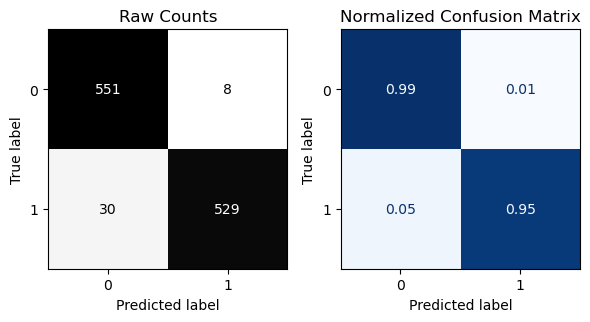


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1655
           1       0.68      0.91      0.78       253

    accuracy                           0.93      1908
   macro avg       0.83      0.92      0.87      1908
weighted avg       0.94      0.93      0.94      1908



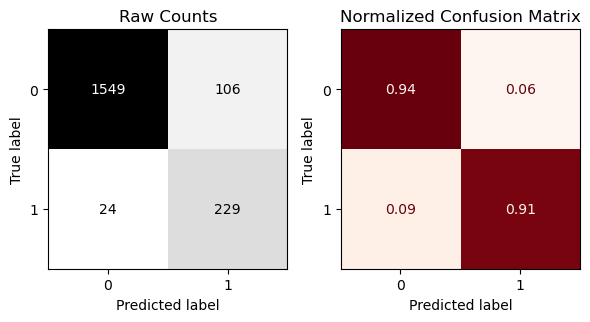

In [23]:
## Create a model pipeline 
count_pipe = Pipeline([('vectorizer',  CountVectorizer()), 
                       ('naivebayes',  MultinomialNB())])

count_pipe.fit(X_train, y_train_enc)
fn.evaluate_classification(count_pipe, X_train, y_train_enc, X_test, y_test_enc,)

## Preparing For Deep NLP (Train-Test-Val Datasets)

Since we already have train/test X and y vars, we will make 2 dataset objects using tf.data.Dataset.from_tensor_slices.

1. The training dataset using X_train, y_train (that we resampled/balanced)
2. The val/test dataset using X_test, y-test.

We will then split the val/test dataset into a val/test split.

<!-- 
### T/T/V Split - Order of Operations (if using 1 dataset object)

1) **Create full dataset object & Shuffle Once.**
2) Calculate number of samples for training and validation data.
3) Create the train/test/val splits using .take() and .skip()
4) **Add shuffle to the train dataset only.**
5) (Optional/Not Used on LP) If applying a transformation (e.g. train_ds.map(...)) to the data, add  here, before .cache()
7) (Optional) Add .cache() to all splits to increase speed  (but may cause problems with large datasets)
8) **Add .batch to all splits (default batch size=32)**
9) (Optional) Add .prefetch(tf.data.AUTOTUNE)
10) (Optional) Print out final length of datasets -->

In [24]:
# Convert training data to Dataset Object
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_enc))
# Shuffle dataset once
train_ds = train_ds.shuffle(len(train_ds), reshuffle_each_iteration=False)

Create a test and validation dataset using X_test,y_test

In [25]:
# Convert test to dataset object to split
val_test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_enc))


In [26]:
# Calculate # of samples for 50/50 val/test split
n_val_samples = int(len(val_test_ds) *.5)
n_val_samples

954

In [27]:
## Perform the val/test split


## Create the validation dataset using .take
val_ds = val_test_ds.take(n_val_samples)

## Create the test dataset using skip
test_ds = val_test_ds.skip(n_val_samples)

In [28]:
# Comparing the len gths of all 3 splits
len(train_ds), len(val_ds), len(test_ds)

(1118, 954, 954)

### Adding Shuffling and Batching

Let's examine a single element.

In [29]:
# display a sample single element 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(b'Easy, Fast and does a Good Job: Easy to use, fast set-up.  It did a great job on the carpet I wanted to rescue.', shape=(), dtype=string) 

 tf.Tensor(0, shape=(), dtype=int64)


In [30]:
# (Repeat) display a sample single element 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(b'Easy, Fast and does a Good Job: Easy to use, fast set-up.  It did a great job on the carpet I wanted to rescue.', shape=(), dtype=string) 

 tf.Tensor(0, shape=(), dtype=int64)


Notice that we have the same example, the training data is not shuffling.

Add .shuffle the training data.

In [31]:
# Shuffle only the training data every epoch
train_ds = train_ds.shuffle(len(train_ds))

In [32]:
# (Repeat) display a sample single element 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(b"I want it to have a good hand tool for washing the carpeted staircase: I don't nee much from a carpet washer. I want it to have a good hand tool for washing the carpeted staircase, and a dirty tank that can be cleaned. My old Bissel had a tank that got packed with fibers that were not even theoretically removable. This tank I can disassemble, wash, dry, and assemble back. Thank you.", shape=(), dtype=string) 

 tf.Tensor(0, shape=(), dtype=int64)


In [33]:
# (Repeat) display a sample single element 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(b'Hoover SteamVac f5914-900 beat my old rainbow hands down: This steamvac made our carpets look like new, we were thinking of replacing them but now we do not have too.  Works well above what I ever thought it could.  Love it and I used to hate cleaning the carpet with the old rainbow.', shape=(), dtype=string) 

 tf.Tensor(0, shape=(), dtype=int64)


> Add batching (use 32 for batch_size)

In [34]:
#  Setting the batch_size for all datasets
BATCH_SIZE =32
# use .batch to add batching to all 3 datasets
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 35 training batches.
 There are 30 validation batches.
 There are 30 testing batches.


In [35]:
# (Repeat) display a sample single element 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)


tf.Tensor(
[b'Two Stars: cumbersome'
 b"Excellent cleaning machine. Keeps my carpets clean for our newborn. Worked great getting rid of tough pet stains too.: I had the Bissell portable unit before this. That one broke, so I gave this a try.\n\nIt is light years ahead of the Bissell, but it costs more so you might expect it to be. I only wish I had bought this first. The additional vacuum-driven cleaning brush is a major bonus too. It's so much easier to spot clean now.\n\nWe just had a baby and I want to keep all our carpets very clean. Before he was born, I used it to clean up our cat's accidents. It does a great job spot cleaning and cleaning large areas. It works as well if not better than the rental ones ... and you don't have to worry about other people's gunk.\n\nThe separate water / detergent chambers make it easy to keep it filled with detergent and not waste any. I just refill the water reservoir with hot water and I'm ready to clean!"
 b'So thrilled with the way it cleans.: 

A single element now contains 32 samples since we set  batch_size to 32.

### Create the Training Texts Dataset

> We need to get a version of our data that is **only the texts**.

In [36]:
# Get just the text_ds from ds_train
text_ds = train_ds.map(lambda x,y: x)
# Preview the text_ds
text_ds.take(1).get_single_element()

2024-01-10 21:49:52.595511: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b"If you have kids or animals or both - you need this.: I usually rent a rug doctor to clean my carpets but I just got tired of that and started to let them go to long so I bought this to keep in the house.  I love it, should have done this years ago when the kids were younger.\nPros:\nEasy to use, not any harder then pushing your vacume around.\nDoes a very nice job\nPrice is good, same as walmart\n\nCon:\nTank is a little small so you have to fill and empty often.  But since I'm not renting it by the hour it's not that big of a deal for me.",
       b"Leaked everywhere, but I got my money back on it: Bought it Nov. 2016.  It's broken a year later.  I bought the 2-year warranty provided by Square Trade, who issued me a full refund, sending me a refund check in the mail and did NOT ask for the machine back.  The machine leaked a bit from the first time I used it, a reported issue in the reviews.  But, I so loved the machine that I pu

### Determine appropriate sequence length. 

In [37]:
# df_ml['length (characters)'] = df_ml['text'].map(len)
# df_ml.head(3)

# ax = sns.histplot(data=df_ml, hue='rating', x='length (characters)',
#                 stat='percent',common_norm=False)#, estimator='median',);
# ax.axvline()

In [38]:
# Let's take a look at the length of the each text
# We will split on each space, and then get the length
df_ml['length (tokens)'] = df_ml['text'].map( lambda x: len(x.split(" ")))
df_ml['length (tokens)'].describe()

count    6359.000000
mean       85.317345
std       105.261462
min         2.000000
25%        21.000000
50%        52.000000
75%       106.000000
max      1521.000000
Name: length (tokens), dtype: float64

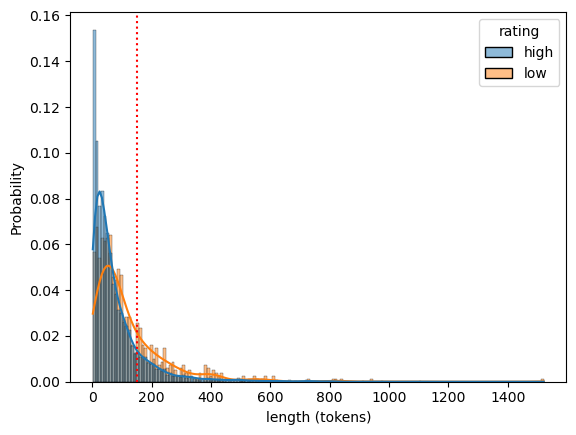

In [39]:
SEQUENCE_LENGTH = 150
ax = sns.histplot(data=df_ml, hue='rating', x='length (tokens)',kde=True,
                stat='probability',common_norm=False)#, estimator='median',);
ax.axvline(SEQUENCE_LENGTH, color='red', ls=":")

# Our First Deep Sequence Model

### Simple RNN

In [40]:

## Create text Vectorization layer
# SEQUENCE_LENGTH = 150
EMBED_DIM = 100

sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

sequence_vectorizer.adapt(text_ds)
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()


In [41]:
# Define sequential model with pre-trained vectorization layer and *new* embedding layer
rnn_model = Sequential([
    sequence_vectorizer,
    layers.Embedding(input_dim=VOCAB_SIZE,
                              output_dim=EMBED_DIM, 
                              input_length=SEQUENCE_LENGTH)
    ])

# Add *new* LSTM layer
rnn_model.add(layers.SimpleRNN(32))

# Add output layer
rnn_model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
rnn_model.compile(optimizer='adam',#optimizers.legacy.Adam(learning_rate = .001), 
              loss='bce',
              metrics=['accuracy'])

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 150)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 150, 100)          588900    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 593,189
Trainable params: 593,189
Non-trainable params: 0
_________________________________________________________________


In [42]:

def get_callbacks(patience=5,#3,
                  monitor='val_accuracy',
                 restore_best_weights=False):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor,
                                                 restore_best_weights=restore_best_weights)
    return [early_stop]

Epoch 1/30
35/35 [==============================] - 1s 20ms/step - loss: 0.6830 - accuracy: 0.5555 - val_loss: 0.6346 - val_accuracy: 0.6279
Epoch 2/30
35/35 [==============================] - 1s 17ms/step - loss: 0.5598 - accuracy: 0.7576 - val_loss: 0.6335 - val_accuracy: 0.6153
Epoch 3/30
35/35 [==============================] - 1s 17ms/step - loss: 0.3825 - accuracy: 0.8766 - val_loss: 0.6519 - val_accuracy: 0.6572
Epoch 4/30
35/35 [==============================] - 1s 17ms/step - loss: 0.2602 - accuracy: 0.9267 - val_loss: 0.6978 - val_accuracy: 0.6604
Epoch 5/30
35/35 [==============================] - 1s 17ms/step - loss: 0.1656 - accuracy: 0.9606 - val_loss: 0.7528 - val_accuracy: 0.6771
Epoch 6/30
35/35 [==============================] - 1s 17ms/step - loss: 0.1265 - accuracy: 0.9714 - val_loss: 0.7680 - val_accuracy: 0.6834
Epoch 7/30
35/35 [==============================] - 1s 18ms/step - loss: 0.1107 - accuracy: 0.9696 - val_loss: 0.8540 - val_accuracy: 0.6834
Epoch 8/30
35

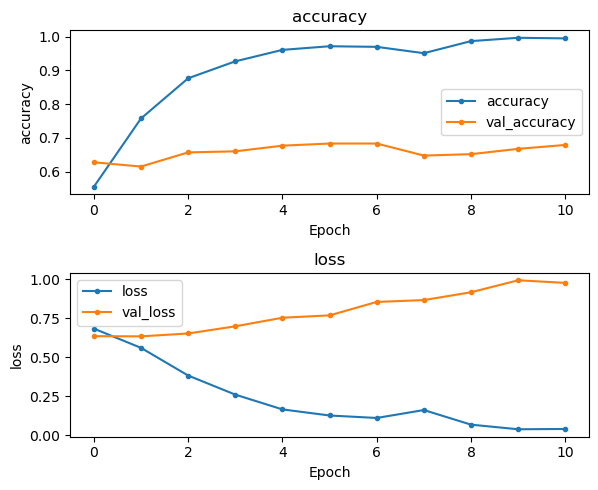

In [43]:
# Define number of epocs
EPOCHS = 30
# Fit the model
history = rnn_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
fn.plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       559
           1       1.00      0.99      1.00       559

    accuracy                           1.00      1118
   macro avg       1.00      1.00      1.00      1118
weighted avg       1.00      1.00      1.00      1118



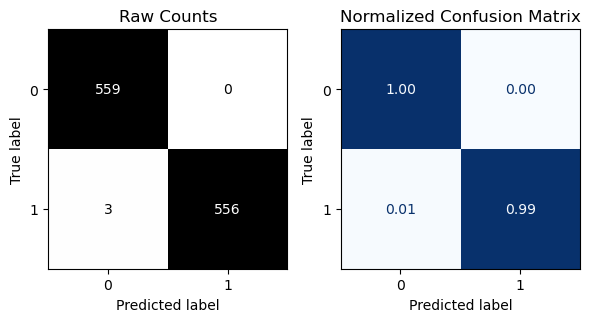


- Evaluating Training Data:
35/35 [==============================] - 0s 4ms/step - loss: 0.0232 - accuracy: 0.9973
{'loss': 0.023190641775727272, 'accuracy': 0.9973166584968567}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.64      0.75       833
           1       0.18      0.53      0.26       121

    accuracy                           0.62       954
   macro avg       0.54      0.58      0.51       954
weighted avg       0.81      0.62      0.69       954



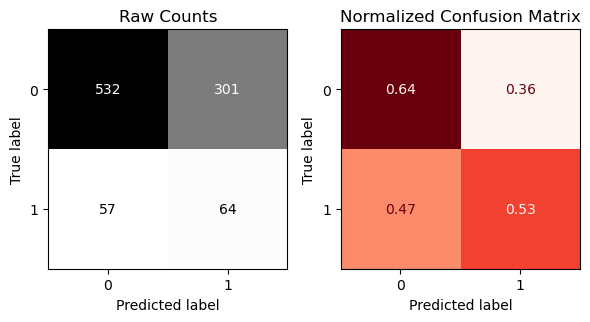


- Evaluating Test Data:
30/30 [==============================] - 0s 3ms/step - loss: 1.1564 - accuracy: 0.6247
{'loss': 1.1563684940338135, 'accuracy': 0.6247379183769226}


In [44]:
# Obtain the results
results = fn.evaluate_classification_network(
    rnn_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

> We will continue with this task and introduce and apply various sequence models.

# 📚 Lecture 02: Comparing Sequence Models

## Plan of Attack

>**We will fit and evaluate several iterations of the following:**
>- SimpleRNN:
    - With recurrent_dropout
    - Returning sequences and Averaging
> - LSTM:
    - Same as SimpleRNN
> - GRU:
    - Same as SimpleRNN

>**We will also try:**
> - Adding a Bidirectional layer
> - Using GloVe Pretrained word embeddings
> - Stacking multiple RNNS layers
    

> **IF there's time**

- saving the best models
- text preprocessing choices (EMBED_DIM, SEQUENCE_LENGTH)
- Make Text Vectorization Option function

 


## Simple RNN

In [45]:
def build_rnn_model(text_vectorization_layer):
    
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add *new* LSTM layer
    model.add(layers.SimpleRNN(32))
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model

def get_callbacks(patience=5,
                  monitor='val_accuracy',
                  start_from_epoch=0,
                 restore_best_weights=False):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor, start_from_epoch=start_from_epoch,
                                                 restore_best_weights=restore_best_weights)
    return [early_stop]

In [46]:
## Create text Vectorization layer
SEQUENCE_LENGTH = 150
EMBED_DIM = 100

sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

sequence_vectorizer.adapt(text_ds)
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 150, 100)          588900    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                4256      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 593,189
Trainable params: 593,189
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
35/35 [==============================] - 1s 19ms/step - loss: 0.6938 - accuracy: 0.5286 - val_loss: 0.6

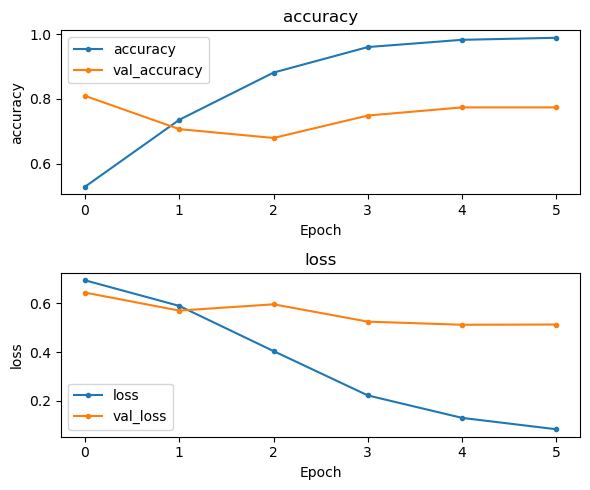

In [47]:
# Build the lstm model and specify the vectorizer
rnn_model = build_rnn_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = rnn_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
fn.plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       559
           1       1.00      1.00      1.00       559

    accuracy                           1.00      1118
   macro avg       1.00      1.00      1.00      1118
weighted avg       1.00      1.00      1.00      1118



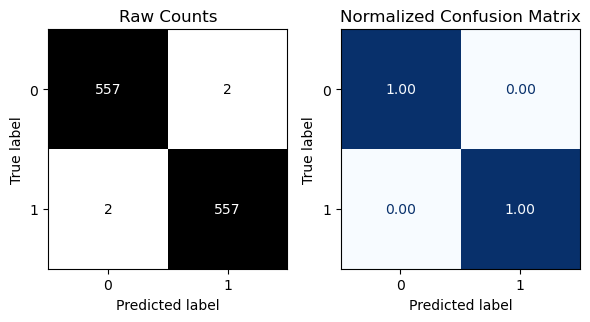


- Evaluating Training Data:
35/35 [==============================] - 0s 4ms/step - loss: 0.0505 - accuracy: 0.9964
{'loss': 0.050548672676086426, 'accuracy': 0.9964221715927124}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.78      0.84       833
           1       0.25      0.51      0.34       121

    accuracy                           0.75       954
   macro avg       0.59      0.65      0.59       954
weighted avg       0.83      0.75      0.78       954



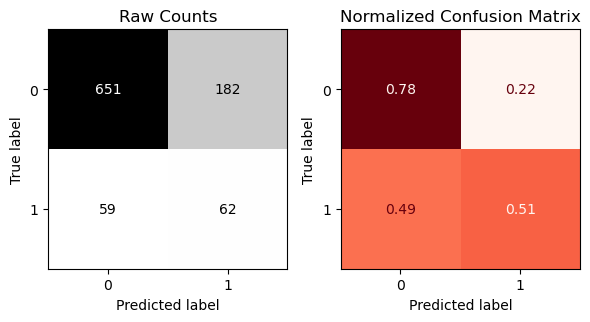


- Evaluating Test Data:
30/30 [==============================] - 0s 4ms/step - loss: 0.5581 - accuracy: 0.7474
{'loss': 0.55812007188797, 'accuracy': 0.74737948179245}


In [48]:
# Obtain the results
results = fn.evaluate_classification_network(
    rnn_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

> This model started overfitting very early. Let's add dropout and recurrent_dropout for the next model to prevent this.

### Adding Recurrent Dropout

In [49]:
def build_rnn_model(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add *new* LSTM layer
    model.add(layers.SimpleRNN(32, recurrent_dropout=0.1, dropout=0.1))
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 150, 100)          588900    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                4256      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 593,189
Trainable params: 593,189
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
35/35 [==============================] - 1s 26ms/step - loss: 0.7080 - accuracy: 0.5224 - val_loss: 0.6

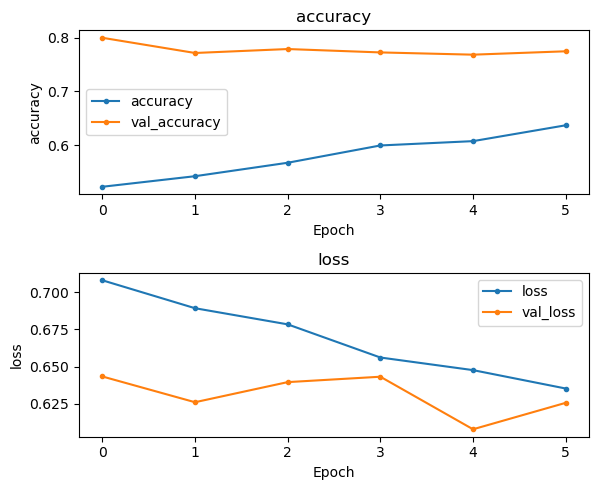

In [50]:
# Build the lstm model and specify the vectorizer
rnn_model = build_rnn_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = rnn_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
fn.plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       559
           1       1.00      0.31      0.47       559

    accuracy                           0.66      1118
   macro avg       0.80      0.66      0.61      1118
weighted avg       0.80      0.66      0.61      1118



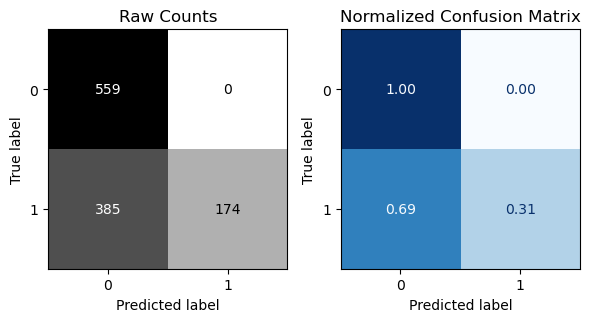


- Evaluating Training Data:
35/35 [==============================] - 0s 3ms/step - loss: 0.5952 - accuracy: 0.6556
{'loss': 0.5952326059341431, 'accuracy': 0.6556350588798523}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       833
           1       0.18      0.18      0.18       121

    accuracy                           0.79       954
   macro avg       0.53      0.53      0.53       954
weighted avg       0.79      0.79      0.79       954



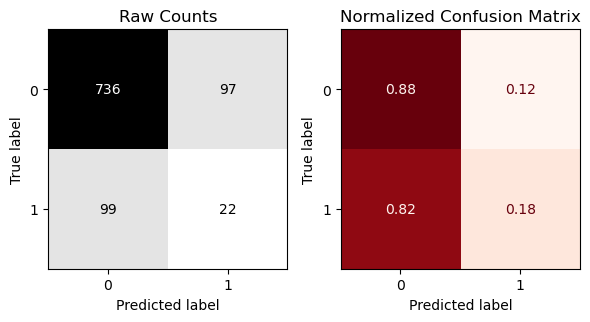


- Evaluating Test Data:
30/30 [==============================] - 0s 3ms/step - loss: 0.6153 - accuracy: 0.7945
{'loss': 0.6152979135513306, 'accuracy': 0.794549286365509}


In [51]:
# Obtain the results
results = fn.evaluate_classification_network(
    rnn_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

> For this particular task/model, adding dropout and recurrent dropout did not seem to help. We could easily spend much more time trying alternative amounts of dropout. Next we will try returning the sequences and averaging them to see if this improves the model. 

## SimpleRNN - Return_sequences = True & Global Pooling

### Demo: 🕹️ Intuition behind Global Pooling

Instead of returning a single final output, we can set the SimpleRNN to return the sequences.
We need to transform/flatten the sequences before the final Dense layer. 

One way to do so is using the average vector.

#### Saving the Previous Model's Embedding Weights

In [52]:
# Slice the embedding layer from the model and use .get_weights()
embedding_weights=rnn_model.layers[1].get_weights()[0]
embedding_weights.shape

(5889, 100)

In [53]:
## Rows = vocab, col = embedding dimensions
sequence_vectorizer.vocabulary_size(), EMBED_DIM

(5889, 100)

In [54]:
# Prepare the words and their corresponding vectors
vector_dict = {}
for i, word in enumerate(sequence_vectorizer.get_vocabulary()):
    # Save the weights for word (based on numeric index)
    vector_dict[word]= embedding_weights[i] 
len(vector_dict)

5889

In [55]:
# Demo vector for love
vector_dict['love']

array([ 0.01089703,  0.04191736,  0.00467662,  0.02602388,  0.00673838,
        0.01614922, -0.01215455, -0.02330791, -0.02572247,  0.02885653,
       -0.06096058,  0.04496519, -0.03802137, -0.00525115, -0.03253091,
        0.01482084, -0.02656694,  0.02413272, -0.00457291,  0.04113441,
        0.0080601 , -0.0212422 , -0.04692122, -0.03271674, -0.02556176,
        0.06003038, -0.03622182,  0.00539959, -0.0242802 ,  0.0220457 ,
       -0.02777105,  0.01180791,  0.03006957,  0.02927708, -0.01077359,
        0.02640005,  0.01942083,  0.01968543,  0.00787752, -0.03006331,
       -0.03452962, -0.04248243, -0.01191301,  0.00764249,  0.01027215,
        0.04577262, -0.02550074,  0.02944242,  0.04996792,  0.03126646,
        0.0015634 ,  0.0035147 ,  0.0341994 ,  0.02520111,  0.00669201,
       -0.01760682,  0.03745892, -0.03987806,  0.01128821,  0.00882921,
        0.01454949,  0.01153471, -0.0218969 ,  0.00151562,  0.00716513,
        0.00972757,  0.0472063 ,  0.06118863,  0.04053809,  0.02

In [56]:
# Confirm embed dim
vector_dict['love'].shape

(100,)

In [57]:
# Confirm embed dim for vacuum
# vector_dict['vaccum']
vector_dict['vaccum'].shape

(100,)

#### Using numpy to calcualte the average vector

Taking the maximum value of 3 vectors to get 1 vector with the mean/average vector

In [58]:
# Stacking the word vectors into 1 array
stacked_vectors  =np.vstack((vector_dict['hate'], vector_dict['love'] ,vector_dict['vacuum']))
stacked_vectors

array([[-0.05257453, -0.00994991,  0.02880146, -0.00452208,  0.00210099,
         0.02915032, -0.02322381,  0.03688278, -0.04125358,  0.00183302,
        -0.03424247, -0.02870961,  0.05100244, -0.01501989, -0.04668308,
        -0.03190508, -0.03969991,  0.04078263, -0.01571599, -0.03260161,
         0.05334784,  0.04674548,  0.04979065,  0.04639237,  0.03429954,
        -0.01451833,  0.01831   ,  0.00678512, -0.0041936 ,  0.0429492 ,
         0.03048564,  0.03254284,  0.05303796, -0.03782462,  0.02179618,
         0.02861791, -0.00520723, -0.00196758, -0.00472676, -0.00459793,
        -0.0134837 ,  0.01073897,  0.02601851,  0.03557942,  0.02656918,
        -0.00542864,  0.04161298, -0.02754002, -0.01605049, -0.0543595 ,
        -0.04114202,  0.02032745, -0.054233  , -0.04227626, -0.01707163,
        -0.02756107, -0.00924474,  0.01583547, -0.02507441, -0.02857906,
         0.03000164, -0.02638676,  0.05101345, -0.00086153, -0.02659515,
         0.02150803, -0.0276384 ,  0.02803535, -0.0

In [59]:
stacked_vectors.shape

(3, 100)

> We now have 3 vectors combined into one matrix. Let's calculate the mean vector with numpy.

In [60]:
# Saving the Average values (relate to GlobalMaxPooling)
avg_vector = np.mean(stacked_vectors,axis=0)
avg_vector

array([ 2.52533704e-04,  3.47254542e-03,  5.54308295e-04, -1.59369688e-02,
        1.63489711e-02,  1.32363020e-02,  4.54179337e-03, -8.19349568e-03,
       -3.11554279e-02,  1.18291890e-02, -2.38231122e-02,  1.33496486e-02,
       -8.35118163e-03,  4.76654060e-03, -1.35079836e-02, -5.13714447e-04,
       -3.53762917e-02,  1.08492887e-02, -2.63406727e-02, -5.33421943e-03,
        3.63745801e-02,  1.21942423e-02,  4.44354862e-03,  3.63696809e-03,
        4.25506989e-03,  3.83991040e-02, -5.30444831e-03, -5.40626189e-03,
       -1.93529446e-02,  3.07810102e-02,  6.81471778e-03,  2.50548515e-02,
        3.64091210e-02, -1.89234808e-04,  1.35977706e-02,  2.01667044e-02,
        2.30439901e-02, -9.84474551e-03, -1.87174771e-02, -1.40270649e-03,
       -2.86194440e-02, -2.14083437e-02,  7.67657161e-03,  1.79835539e-02,
        3.38964723e-03,  2.76376549e-02,  1.44737102e-02,  5.47811389e-03,
        3.17500979e-02, -1.28850723e-02, -1.74383987e-02,  1.88425966e-02,
       -1.83891524e-02,  

> Let's confirm that the shape of the avg vector matches that of a single word vector.

In [61]:
vector_dict['love'].shape, avg_vector.shape

((100,), (100,))

#### Demonstrating the GlobalAveragePooling1D layer

We can accomplish this averaging in the model using the GlobalAveragePooling1D layer. We will demonstrate how this works and prove that it is simply the average vector that we calculated with numpy.

In [62]:
# Creating a model containing only GlobalAveragePooling
average_layer = Sequential(layers.GlobalAveragePooling1D())

# Run the stacked Vectors throught the average pooling layer
try:
    output = average_layer(stacked_vectors)
    print(output.shape)
except Exception as e:
    display(e)


ValueError('Exception encountered when calling layer \'sequential_3\' (type Sequential).\n\nInput 0 of layer "global_average_pooling1d" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (3, 100)\n\nCall arguments received by layer \'sequential_3\' (type Sequential):\n  • inputs=tf.Tensor(shape=(3, 100), dtype=float32)\n  • training=None\n  • mask=None')

- The model expected a 3D tensor instead of a 2D one. We can add an empty extra dimension using `tf.expand_dims`

In [63]:
# Adding a third dimension to prevent errors
stacked_vectors_tf = tf.expand_dims(stacked_vectors,0)
stacked_vectors_tf.shape

TensorShape([1, 3, 100])

In [64]:
# View the new tensor with the expanded dims
stacked_vectors_tf

<tf.Tensor: shape=(1, 3, 100), dtype=float32, numpy=
array([[[-0.05257453, -0.00994991,  0.02880146, -0.00452208,
          0.00210099,  0.02915032, -0.02322381,  0.03688278,
         -0.04125358,  0.00183302, -0.03424247, -0.02870961,
          0.05100244, -0.01501989, -0.04668308, -0.03190508,
         -0.03969991,  0.04078263, -0.01571599, -0.03260161,
          0.05334784,  0.04674548,  0.04979065,  0.04639237,
          0.03429954, -0.01451833,  0.01831   ,  0.00678512,
         -0.0041936 ,  0.0429492 ,  0.03048564,  0.03254284,
          0.05303796, -0.03782462,  0.02179618,  0.02861791,
         -0.00520723, -0.00196758, -0.00472676, -0.00459793,
         -0.0134837 ,  0.01073897,  0.02601851,  0.03557942,
          0.02656918, -0.00542864,  0.04161298, -0.02754002,
         -0.01605049, -0.0543595 , -0.04114202,  0.02032745,
         -0.054233  , -0.04227626, -0.01707163, -0.02756107,
         -0.00924474,  0.01583547, -0.02507441, -0.02857906,
          0.03000164, -0.0263867

In [65]:
# Create a model containing only GlobalAveragePooling
average_layer = Sequential(layers.GlobalAveragePooling1D())

# Run the stacked Vectors throught the average pooling layer
output = average_layer(stacked_vectors_tf)
output.shape

TensorShape([1, 100])

In [66]:
# Show the output from the global pooling layer (as a numpy array)
output.numpy()

array([[ 2.52533704e-04,  3.47254542e-03,  5.54308295e-04,
        -1.59369688e-02,  1.63489711e-02,  1.32363020e-02,
         4.54179337e-03, -8.19349568e-03, -3.11554279e-02,
         1.18291890e-02, -2.38231122e-02,  1.33496486e-02,
        -8.35118163e-03,  4.76654060e-03, -1.35079836e-02,
        -5.13714447e-04, -3.53762917e-02,  1.08492887e-02,
        -2.63406727e-02, -5.33421943e-03,  3.63745801e-02,
         1.21942423e-02,  4.44354862e-03,  3.63696809e-03,
         4.25506989e-03,  3.83991040e-02, -5.30444831e-03,
        -5.40626189e-03, -1.93529446e-02,  3.07810102e-02,
         6.81471778e-03,  2.50548515e-02,  3.64091210e-02,
        -1.89234808e-04,  1.35977706e-02,  2.01667044e-02,
         2.30439901e-02, -9.84474551e-03, -1.87174771e-02,
        -1.40270649e-03, -2.86194440e-02, -2.14083437e-02,
         7.67657161e-03,  1.79835539e-02,  3.38964723e-03,
         2.76376549e-02,  1.44737102e-02,  5.47811389e-03,
         3.17500979e-02, -1.28850723e-02, -1.74383987e-0

In [67]:
# Confirm the GlobalAverage Pooling layer returns same result as the avg_vector
(output.numpy() == avg_vector).all()

True

In [68]:
# Confirming the GlobalAverage Pooling layer returns same result
np.isclose(output.numpy(), avg_vector).all()

True

> Now let's add this to the model and see how it performs.

### Using GlobalAveragePooling1D in Model

- We must set return_sequences = True  for the RNN layer, and then add the GlobalAveragePooling1D layer.

In [69]:
def build_rnn_model_pool(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add *new* LSTM layer
    model.add(layers.SimpleRNN(32,return_sequences=True))

    ## 
    model.add(layers.GlobalAveragePooling1D())
              
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 150, 100)          588900    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 150, 32)           4256      
                                                                 
 global_average_pooling1d_2   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 593,189
Trainable params: 593,189
Non-tr

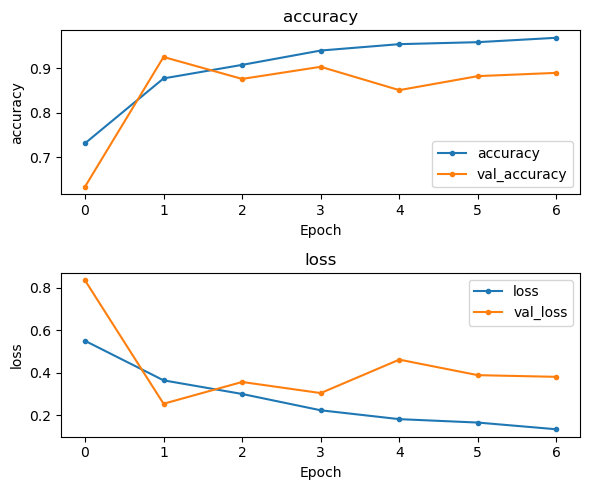

In [70]:
# Build the lstm model and specify the vectorizer
rnn_model_pool = build_rnn_model_pool(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = rnn_model_pool.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
fn.plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       559
           1       0.98      0.98      0.98       559

    accuracy                           0.98      1118
   macro avg       0.98      0.98      0.98      1118
weighted avg       0.98      0.98      0.98      1118



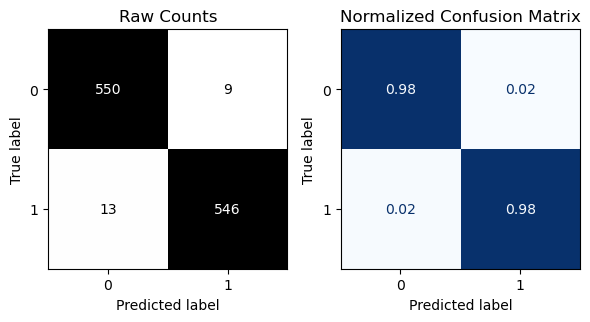


- Evaluating Training Data:
35/35 [==============================] - 0s 4ms/step - loss: 0.0978 - accuracy: 0.9803
{'loss': 0.09776011109352112, 'accuracy': 0.980322003364563}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.90      0.94       833
           1       0.55      0.83      0.66       121

    accuracy                           0.89       954
   macro avg       0.76      0.87      0.80       954
weighted avg       0.92      0.89      0.90       954



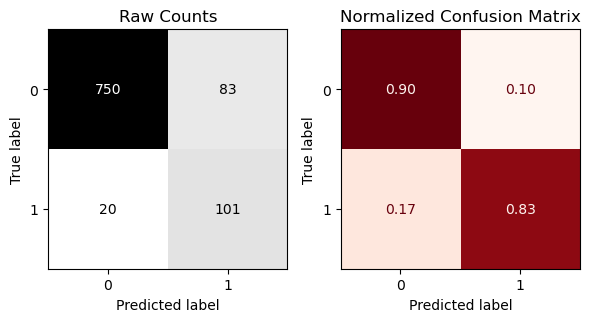


- Evaluating Test Data:
30/30 [==============================] - 0s 4ms/step - loss: 0.3765 - accuracy: 0.8920
{'loss': 0.3764994442462921, 'accuracy': 0.8920335173606873}


In [71]:
# Obtain the results
results = fn.evaluate_classification_network(
    rnn_model_pool, X_train=train_ds, 
    X_test=test_ds,# history=history
);

> Using the average vector helped our model a lot. Notice how high the recall score is for the 1 class.  However, its still overfitting so lets try adding recurrent dropout and dropout regularization.

###  Using Recurrent Dropout + return_sequences=True and Global Pooling layer 

In [72]:
def build_rnn_model_pool(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add *new* SimpleRNN layer
    model.add(layers.SimpleRNN(32,recurrent_dropout=.2, dropout=.1,return_sequences=True))

    ## 
    model.add(layers.GlobalAveragePooling1D())
              
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 150, 100)          588900    
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 150, 32)           4256      
                                                                 
 global_average_pooling1d_3   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 593,189
Trainable params: 593,189
Non-tr

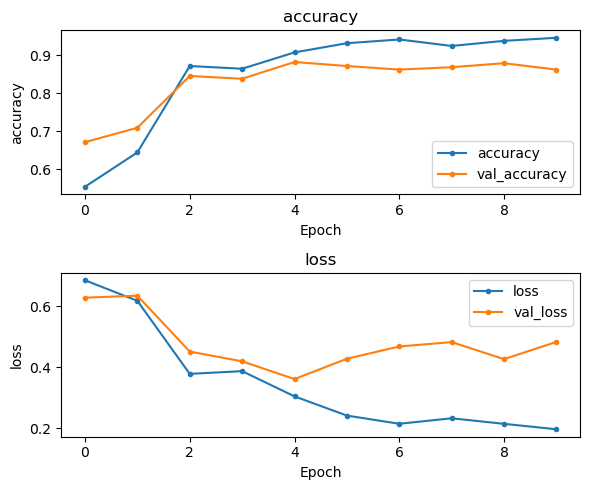

In [73]:
## Build the lstm model and specify the vectorizer
rnn_model_pool = build_rnn_model_pool(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = rnn_model_pool.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
fn.plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       559
           1       0.96      0.97      0.96       559

    accuracy                           0.96      1118
   macro avg       0.96      0.96      0.96      1118
weighted avg       0.96      0.96      0.96      1118



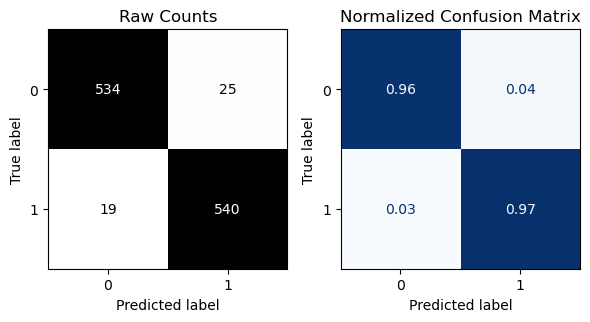


- Evaluating Training Data:
35/35 [==============================] - 0s 4ms/step - loss: 0.1588 - accuracy: 0.9606
{'loss': 0.15880416333675385, 'accuracy': 0.960644006729126}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       833
           1       0.44      0.90      0.60       121

    accuracy                           0.84       954
   macro avg       0.71      0.87      0.75       954
weighted avg       0.91      0.84      0.86       954



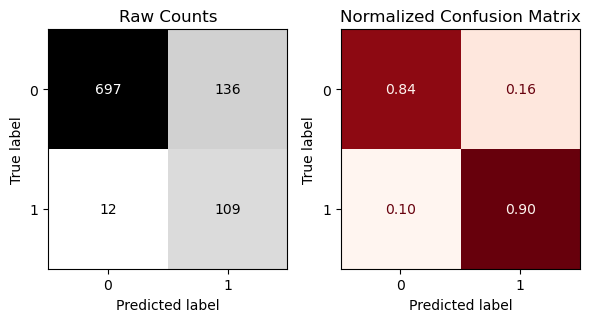


- Evaluating Test Data:
30/30 [==============================] - 0s 4ms/step - loss: 0.5408 - accuracy: 0.8449
{'loss': 0.5407519340515137, 'accuracy': 0.8448637127876282}


In [74]:
# Obtain the results
results = fn.evaluate_classification_network(
    rnn_model_pool, X_train=train_ds, 
    X_test=test_ds,# history=history
);

> Adding dropout and recurrent dropout helped our model a lot! We have a higher accuracy, and better recall for the 0 class.

There's a lot more we could tune, but let's move onto the next sequence model that was developed: the LSTM.

## LSTM

In [75]:
def build_lstm_model(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add *new* LSTM layer
    model.add(layers.LSTM(32))
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model

# def get_callbacks(patience=3, monitor='val_accuracy'):
#     early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
#     return [early_stop]

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 150, 100)          588900    
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 605,957
Trainable params: 605,957
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
35/35 [==============================] - 2s 38ms/step - loss: 0.6886 - accuracy: 0.5546 - val_loss: 0.6

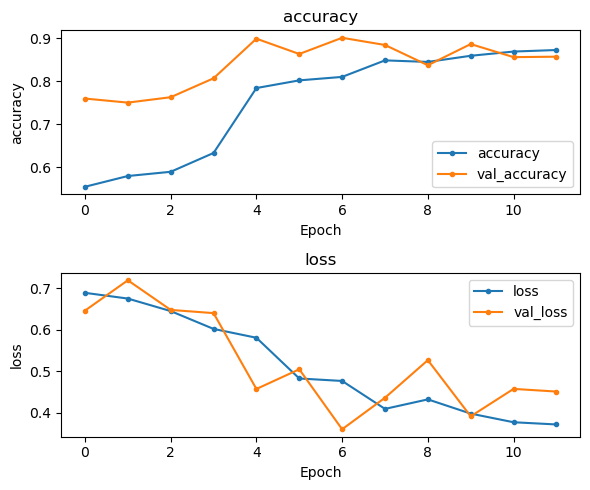

In [76]:
# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
fn.plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       559
           1       0.92      0.82      0.87       559

    accuracy                           0.87      1118
   macro avg       0.88      0.87      0.87      1118
weighted avg       0.88      0.87      0.87      1118



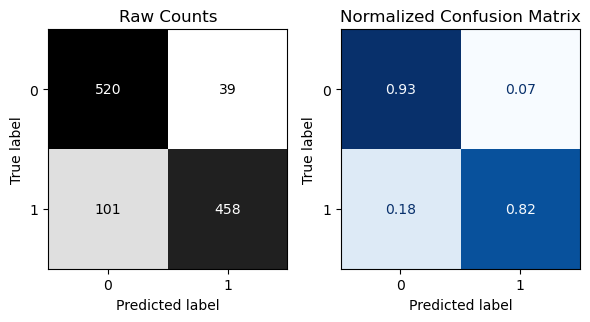


- Evaluating Training Data:
35/35 [==============================] - 0s 7ms/step - loss: 0.3641 - accuracy: 0.8748
{'loss': 0.3640754818916321, 'accuracy': 0.8747763633728027}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       833
           1       0.47      0.74      0.58       121

    accuracy                           0.86       954
   macro avg       0.71      0.81      0.75       954
weighted avg       0.90      0.86      0.87       954



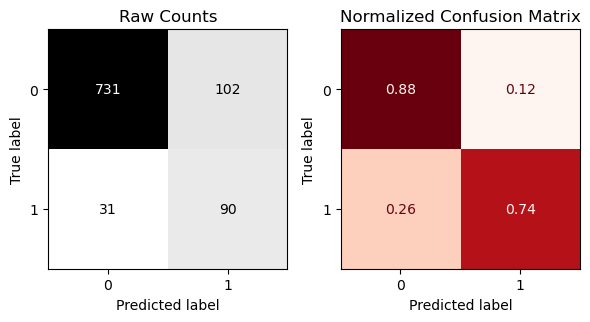


- Evaluating Test Data:
30/30 [==============================] - 0s 7ms/step - loss: 0.4483 - accuracy: 0.8606
{'loss': 0.44833606481552124, 'accuracy': 0.8605870008468628}


In [77]:
# Obtain the results
results = fn.evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

> the baseline LSTM is already outperforming our SimpleRNN model.  Let's try using the average word vectors again, since overfitting isn't as much of an issue vs. our earlier SimpleRNN.

###  Using return_sequences=True and Global Pooling layer

In [78]:
def build_lstm_model(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add *new* LSTM layer
    model.add(layers.LSTM(32,return_sequences=True))
    model.add(layers.GlobalAveragePooling1D())
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_6 (Embedding)     (None, 150, 100)          588900    
                                                                 
 lstm_1 (LSTM)               (None, 150, 32)           17024     
                                                                 
 global_average_pooling1d_4   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 605,957
Trainable params: 605,957
Non-tr

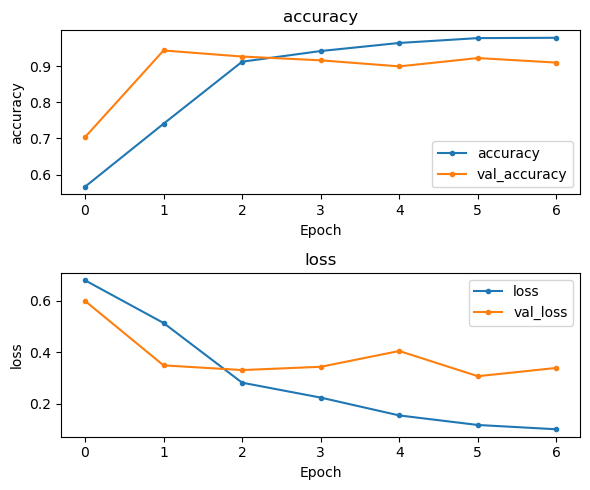

In [79]:

# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
fn.plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       559
           1       0.99      0.99      0.99       559

    accuracy                           0.99      1118
   macro avg       0.99      0.99      0.99      1118
weighted avg       0.99      0.99      0.99      1118



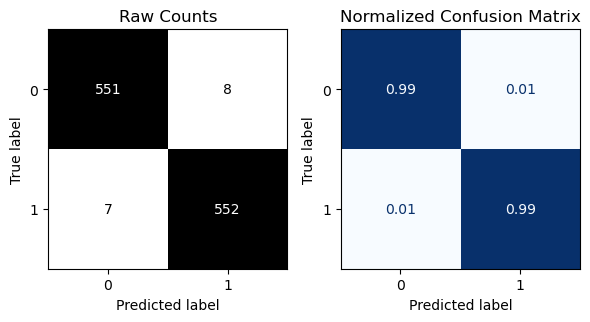


- Evaluating Training Data:
35/35 [==============================] - 0s 7ms/step - loss: 0.0756 - accuracy: 0.9866
{'loss': 0.07562036067247391, 'accuracy': 0.9865831732749939}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       833
           1       0.58      0.90      0.71       121

    accuracy                           0.90       954
   macro avg       0.78      0.90      0.82       954
weighted avg       0.93      0.90      0.91       954



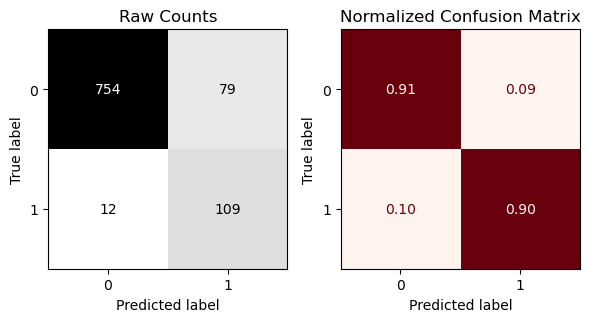


- Evaluating Test Data:
30/30 [==============================] - 0s 7ms/step - loss: 0.3687 - accuracy: 0.9046
{'loss': 0.36871138215065, 'accuracy': 0.9046121835708618}


In [80]:
# Obtain the results
results = fn.evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

> Using the average sequence has helped our LSTM model as well. We have better accuracy and recall scores for both classes. The model started to overfit, so let's add recurrent dropout and dropout again.

### Add Dropout/Recurrent Dropout

In [81]:
def build_lstm_model(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add *new* LSTM layer
    model.add(layers.LSTM(32,recurrent_dropout=.2,dropout=.2, return_sequences=True))#, recurrent_dropout=.2, dropout=.1))
    model.add(layers.GlobalAveragePooling1D())
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_7 (Embedding)     (None, 150, 100)          588900    
                                                                 
 lstm_2 (LSTM)               (None, 150, 32)           17024     
                                                                 
 global_average_pooling1d_5   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 605,957
Trainable params: 605,957
Non-tr

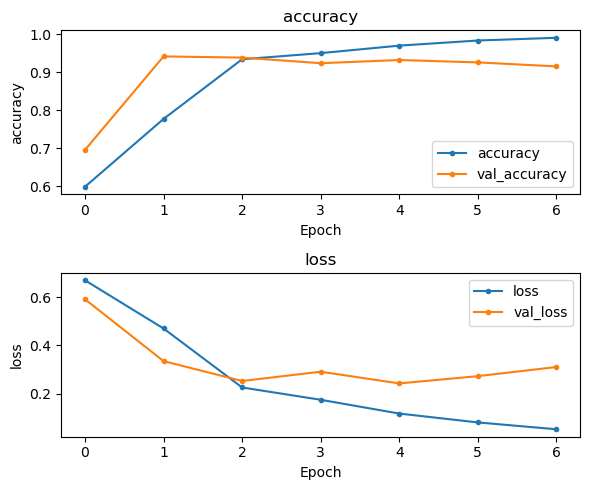

In [82]:
# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
fn.plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       559
           1       0.99      1.00      1.00       559

    accuracy                           1.00      1118
   macro avg       1.00      1.00      1.00      1118
weighted avg       1.00      1.00      1.00      1118



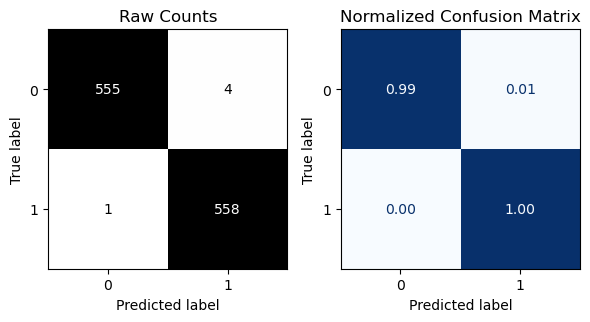


- Evaluating Training Data:
35/35 [==============================] - 0s 9ms/step - loss: 0.0321 - accuracy: 0.9955
{'loss': 0.032129425555467606, 'accuracy': 0.9955277442932129}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.89      0.94       833
           1       0.55      0.90      0.69       121

    accuracy                           0.90       954
   macro avg       0.77      0.90      0.81       954
weighted avg       0.93      0.90      0.91       954



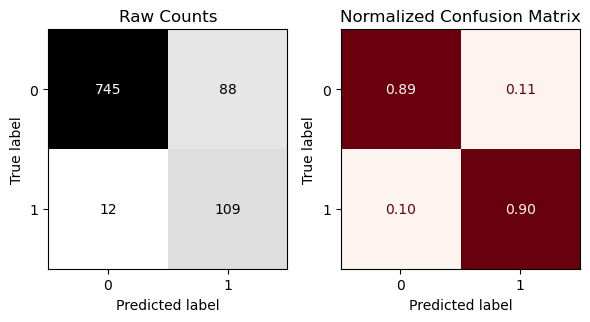


- Evaluating Test Data:
30/30 [==============================] - 0s 10ms/step - loss: 0.3752 - accuracy: 0.8952
{'loss': 0.37522104382514954, 'accuracy': 0.8951781988143921}


In [83]:
# Obtain the results
results = fn.evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

> Adding dropout and recurrent_dropout has helped our model again! There are still other parameters we would try, but let's move onto the next sequence model that was developed: the GRU.

## GRU

In [84]:
def build_gru_model(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add a GRU layer
    model.add(layers.GRU(32)) 
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_8 (Embedding)     (None, 150, 100)          588900    
                                                                 
 gru (GRU)                   (None, 32)                12864     
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 601,797
Trainable params: 601,797
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
35/35 [==============================] - 2s 37ms/step - loss: 0.6895 - accuracy: 0.5420 - val_loss: 0.

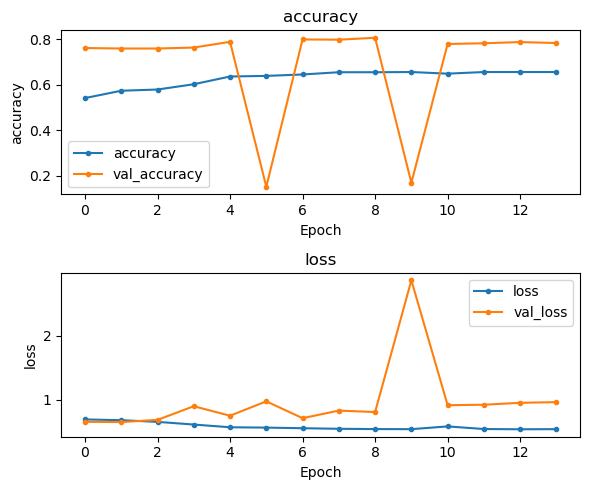

In [85]:
# Build the lstm model and specify the vectorizer
gru_model = build_gru_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = gru_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
fn.plot_history(history, figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       559
           1       1.00      0.31      0.48       559

    accuracy                           0.66      1118
   macro avg       0.80      0.66      0.61      1118
weighted avg       0.80      0.66      0.61      1118



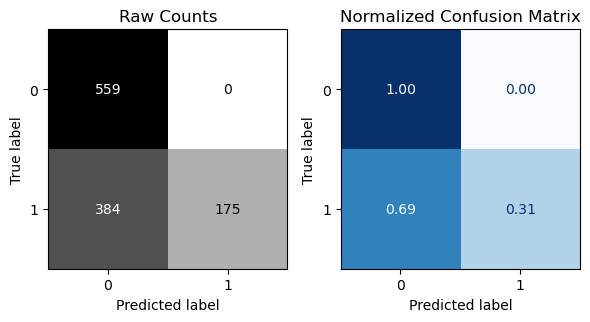


- Evaluating Training Data:
35/35 [==============================] - 0s 6ms/step - loss: 0.5333 - accuracy: 0.6565
{'loss': 0.5332651138305664, 'accuracy': 0.6565295457839966}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       833
           1       0.22      0.21      0.22       121

    accuracy                           0.80       954
   macro avg       0.55      0.55      0.55       954
weighted avg       0.80      0.80      0.80       954



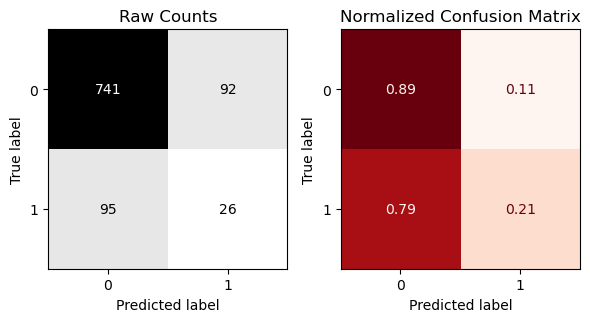


- Evaluating Test Data:
30/30 [==============================] - 0s 6ms/step - loss: 0.8834 - accuracy: 0.8040
{'loss': 0.8834019899368286, 'accuracy': 0.803983211517334}


In [86]:
# Obtain the results
results = fn.evaluate_classification_network(
    gru_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

> The basline GRU is peforming much worse than the baseline LSTM. The accuracy and val_accuracy stayed pretty flat for beginning of the training. We can try increasing the number of GRU units and a faster learnin rate.

> `???` The model is very biased towards predicting the 0 class and is overfit.
> We could spend time tuning things like the number of units and the learning rate, but for now let's try adding dropout and recurrent dropout regularization.

### GRU + More Units + Learning Rate

In [87]:
def build_gru_model(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add a GRU layer
    model.add(layers.GRU(64)) 
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_9 (Embedding)     (None, 150, 100)          588900    
                                                                 
 gru_1 (GRU)                 (None, 64)                31872     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 620,837
Trainable params: 620,837
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
35/35 [==============================] - 2s 50ms/step - loss: 0.6989 - accuracy: 0.5009 - val_loss: 0.

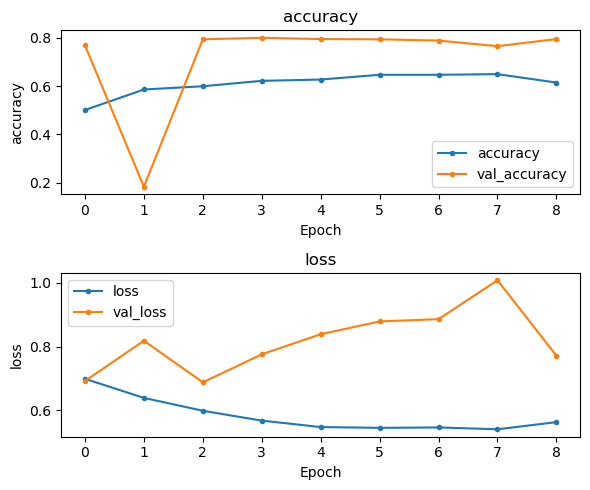

In [88]:
# Build the lstm model and specify the vectorizer
gru_model = build_gru_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = gru_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
fn.plot_history(history, figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.58      1.00      0.74       559
           1       1.00      0.29      0.45       559

    accuracy                           0.64      1118
   macro avg       0.79      0.64      0.59      1118
weighted avg       0.79      0.64      0.59      1118



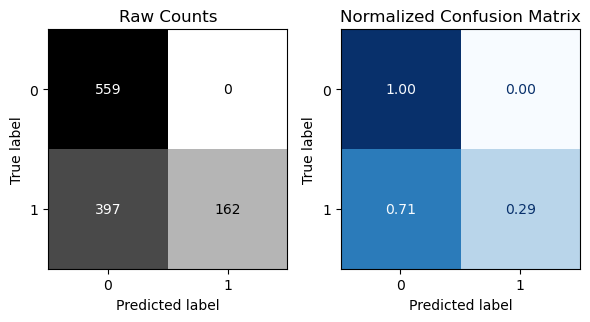


- Evaluating Training Data:
35/35 [==============================] - 0s 9ms/step - loss: 0.5535 - accuracy: 0.6449
{'loss': 0.5535269379615784, 'accuracy': 0.6449016332626343}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       833
           1       0.20      0.14      0.16       121

    accuracy                           0.82       954
   macro avg       0.54      0.53      0.53       954
weighted avg       0.79      0.82      0.80       954



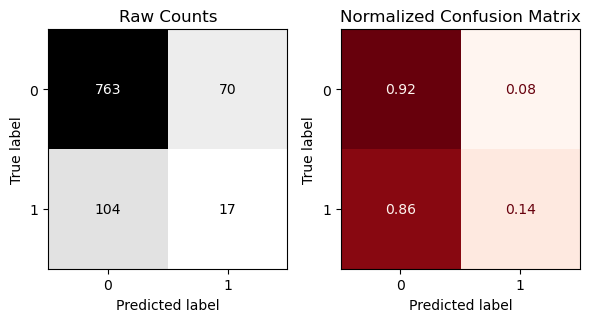


- Evaluating Test Data:
30/30 [==============================] - 0s 9ms/step - loss: 0.7263 - accuracy: 0.8176
{'loss': 0.7262519001960754, 'accuracy': 0.8176100850105286}


In [89]:
# Obtain the results
results = fn.evaluate_classification_network(
    gru_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

> The increased complexity (nunits) plus faster learning rate helped dramatically! The model is overfitting so let's add dropout as well.

### Add Dropout/Recurrent Dropout

In [90]:
def build_gru_model(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add GRU layer
    model.add(layers.GRU(64,recurrent_dropout=.1, dropout=.3))#, recurrent_dropout=.2, dropout=.1))
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_10 (Embedding)    (None, 150, 100)          588900    
                                                                 
 gru_2 (GRU)                 (None, 64)                31872     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 620,837
Trainable params: 620,837
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
35/35 [==============================] - 4s 99ms/step - loss: 0.6894 - accuracy: 0.5394 - val_loss: 0.

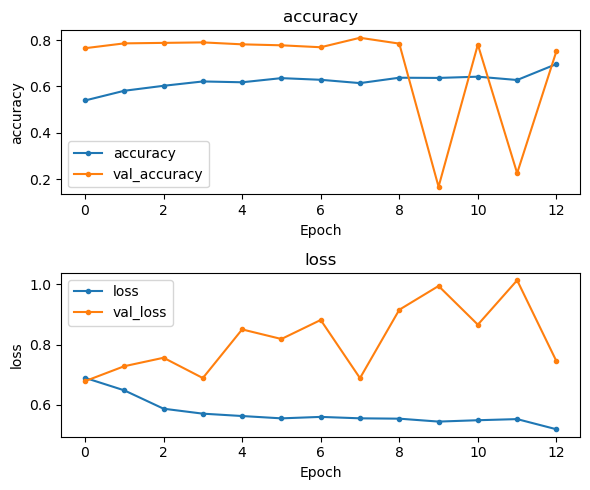

In [91]:
# Build the lstm model and specify the vectorizer
gru_model = build_gru_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = gru_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
fn.plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.97      0.82       559
           1       0.95      0.60      0.74       559

    accuracy                           0.79      1118
   macro avg       0.83      0.79      0.78      1118
weighted avg       0.83      0.79      0.78      1118



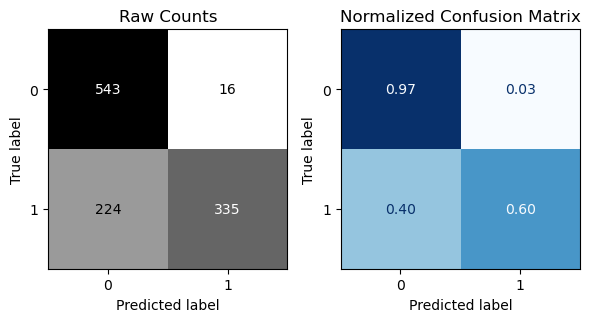


- Evaluating Training Data:
35/35 [==============================] - 0s 11ms/step - loss: 0.4484 - accuracy: 0.7853
{'loss': 0.44842439889907837, 'accuracy': 0.7853309512138367}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       833
           1       0.21      0.32      0.25       121

    accuracy                           0.76       954
   macro avg       0.55      0.57      0.55       954
weighted avg       0.81      0.76      0.78       954



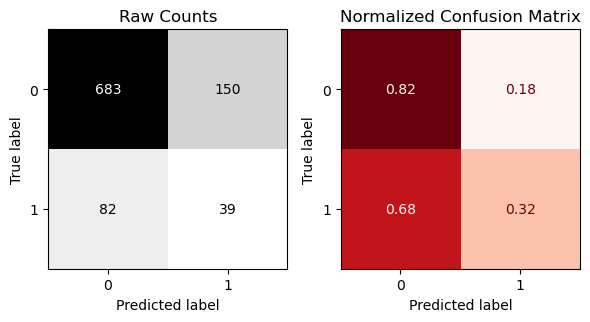


- Evaluating Test Data:
30/30 [==============================] - 0s 11ms/step - loss: 0.6890 - accuracy: 0.7568
{'loss': 0.688961386680603, 'accuracy': 0.7568134069442749}


In [92]:
# Obtain the results
results = fn.evaluate_classification_network(
    gru_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

> ...

### Using Return Sequences = True + GlobalAveragePooling

In [93]:
def build_gru_model(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add GRU layer
    model.add(layers.GRU(64,recurrent_dropout=.1,dropout=.1,return_sequences=True))
    model.add(layers.GlobalAveragePooling1D())
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_11 (Embedding)    (None, 150, 100)          588900    
                                                                 
 gru_3 (GRU)                 (None, 150, 64)           31872     
                                                                 
 global_average_pooling1d_6   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 620,837
Trainable params: 620,837
Non-t

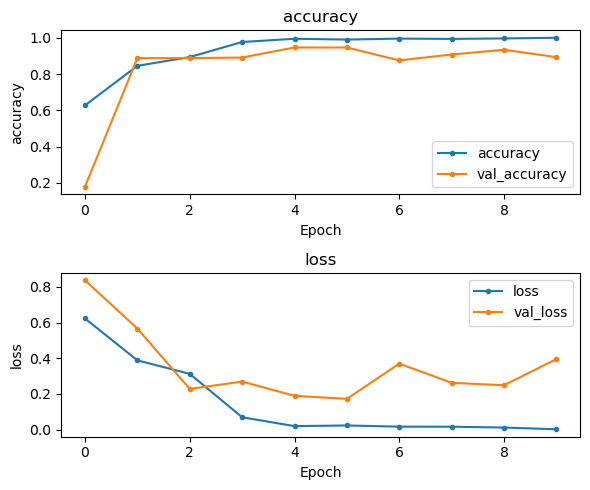

In [94]:
# Build the lstm model and specify the vectorizer
gru_model = build_gru_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = gru_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
fn.plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       559
           1       1.00      1.00      1.00       559

    accuracy                           1.00      1118
   macro avg       1.00      1.00      1.00      1118
weighted avg       1.00      1.00      1.00      1118



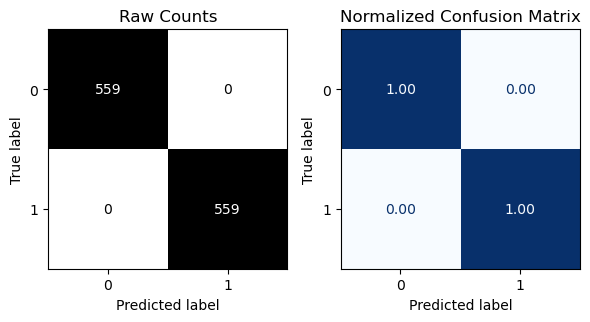


- Evaluating Training Data:
35/35 [==============================] - 0s 11ms/step - loss: 6.3406e-04 - accuracy: 1.0000
{'loss': 0.0006340640247799456, 'accuracy': 1.0}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       833
           1       0.54      0.93      0.68       121

    accuracy                           0.89       954
   macro avg       0.76      0.90      0.81       954
weighted avg       0.93      0.89      0.90       954



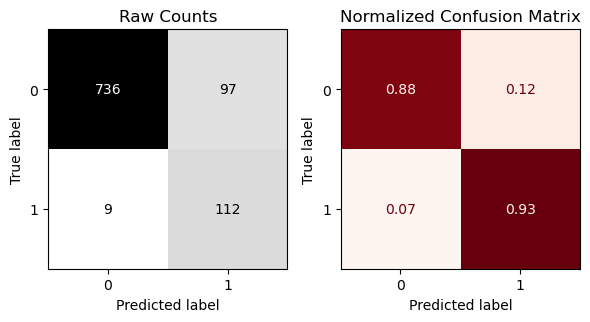


- Evaluating Test Data:
30/30 [==============================] - 0s 11ms/step - loss: 0.3837 - accuracy: 0.8889
{'loss': 0.3837375044822693, 'accuracy': 0.8888888955116272}


In [95]:
# Obtain the results
results = fn.evaluate_classification_network(
    gru_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

>  ...

## Bidirectional

In [96]:
def build_bi_gru_model(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add *new* LSTM layer
    model.add(layers.Bidirectional(layers.GRU(64),))
    # model.add(layers.GlobalAveragePooling1D())
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model

# def get_callbacks(patience=3, monitor='val_accuracy'):
#     early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
#     return [early_stop]

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_12 (Embedding)    (None, 150, 100)          588900    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              63744     
 l)                                                              
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 652,773
Trainable params: 652,773
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
35/35 [=============================

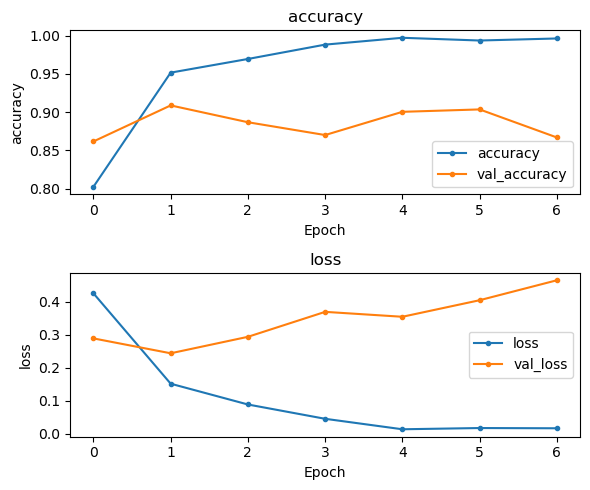

In [97]:
# Build the lstm model and specify the vectorizer
bi_gru_model = build_bi_gru_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = bi_gru_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
fn.plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       559
           1       0.99      0.99      0.99       559

    accuracy                           0.99      1118
   macro avg       0.99      0.99      0.99      1118
weighted avg       0.99      0.99      0.99      1118



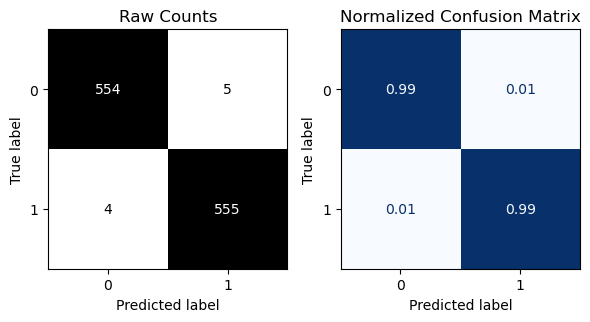


- Evaluating Training Data:
35/35 [==============================] - 0s 10ms/step - loss: 0.0236 - accuracy: 0.9919
{'loss': 0.023610876873135567, 'accuracy': 0.9919499158859253}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       833
           1       0.49      0.88      0.63       121

    accuracy                           0.87       954
   macro avg       0.74      0.88      0.78       954
weighted avg       0.92      0.87      0.88       954



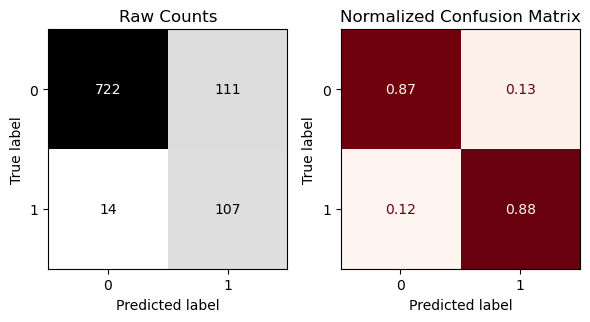


- Evaluating Test Data:
30/30 [==============================] - 0s 10ms/step - loss: 0.4876 - accuracy: 0.8690
{'loss': 0.4876340925693512, 'accuracy': 0.8689727187156677}


In [98]:
# Obtain the results
results = fn.evaluate_classification_network(
    bi_gru_model, X_train=train_ds, 
    X_test=test_ds, # history=history
);

> ...Could try much more

## Pre-trained Word Embeddings

###  Using GloVe Embeddings

- [Click here](https://nlp.stanford.edu/data/glove.6B.zip) to start donwnloading GloVe zip file (glove.6B.zip)
- Unzip the downloaded zip archive.
- Open the extracted folder and find the the `glove.6B.100d.txt` file. (Size is over 300MB )
- Move the text file from Downloads to the same folder as this notebook.
- **Make sure to ignore the large file using GitHub Desktop**

In [99]:
from gensim.models import KeyedVectors
# Load GloVe vectors into a gensim model
glove_model = KeyedVectors.load_word2vec_format("../Lecture 1/glove.6B.100d.txt", binary=False, no_header=True)

In [100]:
# You can now use `glove_model` to access individual word vectors, similar to a dictionary
vector = glove_model['king']
vector

array([-0.32307 , -0.87616 ,  0.21977 ,  0.25268 ,  0.22976 ,  0.7388  ,
       -0.37954 , -0.35307 , -0.84369 , -1.1113  , -0.30266 ,  0.33178 ,
       -0.25113 ,  0.30448 , -0.077491, -0.89815 ,  0.092496, -1.1407  ,
       -0.58324 ,  0.66869 , -0.23122 , -0.95855 ,  0.28262 , -0.078848,
        0.75315 ,  0.26584 ,  0.3422  , -0.33949 ,  0.95608 ,  0.065641,
        0.45747 ,  0.39835 ,  0.57965 ,  0.39267 , -0.21851 ,  0.58795 ,
       -0.55999 ,  0.63368 , -0.043983, -0.68731 , -0.37841 ,  0.38026 ,
        0.61641 , -0.88269 , -0.12346 , -0.37928 , -0.38318 ,  0.23868 ,
        0.6685  , -0.43321 , -0.11065 ,  0.081723,  1.1569  ,  0.78958 ,
       -0.21223 , -2.3211  , -0.67806 ,  0.44561 ,  0.65707 ,  0.1045  ,
        0.46217 ,  0.19912 ,  0.25802 ,  0.057194,  0.53443 , -0.43133 ,
       -0.34311 ,  0.59789 , -0.58417 ,  0.068995,  0.23944 , -0.85181 ,
        0.30379 , -0.34177 , -0.25746 , -0.031101, -0.16285 ,  0.45169 ,
       -0.91627 ,  0.64521 ,  0.73281 , -0.22752 , 

In [101]:
vector.shape

(100,)

In [102]:
# Find similarity between words
glove_model.similarity('king', 'queen')

0.7507691

In [103]:
# Perform word math
result = glove_model.most_similar(positive=['woman', 'king'], negative=['man'], topn=5)
result

[('queen', 0.7698541283607483),
 ('monarch', 0.6843380331993103),
 ('throne', 0.6755736470222473),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534157752991)]

In [104]:
# We can use glove to calculate the most similar
glove_model.most_similar('king')

[('prince', 0.7682329416275024),
 ('queen', 0.7507689595222473),
 ('son', 0.7020888328552246),
 ('brother', 0.6985775828361511),
 ('monarch', 0.6977890729904175),
 ('throne', 0.691999077796936),
 ('kingdom', 0.6811410188674927),
 ('father', 0.6802029013633728),
 ('emperor', 0.6712858080863953),
 ('ii', 0.6676074266433716)]

In [105]:
# Manually calculating new vector for word math
new_vector = glove_model['king'] - glove_model['man'] + glove_model['woman']
new_vector

array([-0.10231996, -0.81294006,  0.10211003,  0.985924  ,  0.34218282,
        1.09095   , -0.48912996, -0.05616698, -0.21029997, -1.02996   ,
       -0.86851   ,  0.36786997,  0.01960999,  0.59259   , -0.23190099,
       -1.016919  , -0.01218399, -1.17194   , -0.52329   ,  0.60645   ,
       -0.98537004, -1.001028  ,  0.48913902,  0.630072  ,  0.58224   ,
        0.15908998,  0.43685   , -1.25351   ,  0.97054   , -0.065529  ,
        0.733763  ,  0.44219002,  1.2091839 ,  0.19698   , -0.15948   ,
        0.34364003, -0.46222997,  0.33772   ,  0.14792705, -0.24959502,
       -0.77093005,  0.522717  , -0.1283    , -0.91881   , -0.01755001,
       -0.44041002, -0.52656496,  0.33734798,  0.60639   , -0.45067   ,
       -0.04158002,  0.08408299,  1.31456   ,  0.67737997, -0.24316001,
       -2.071     , -0.60648996,  0.19710997,  0.63567   ,  0.07819998,
        0.49161002,  0.08171999,  0.70855707,  0.201938  ,  0.5155501 ,
       -0.23025298, -0.40473002,  0.39212003, -0.5093    , -0.13

In [106]:
# Using .most_similar with an array
glove_model.most_similar(new_vector)

[('king', 0.8551837205886841),
 ('queen', 0.7834413647651672),
 ('monarch', 0.6933802366256714),
 ('throne', 0.6833109259605408),
 ('daughter', 0.680908203125),
 ('prince', 0.6713142991065979),
 ('princess', 0.664408266544342),
 ('mother', 0.6579325199127197),
 ('elizabeth', 0.6563301086425781),
 ('father', 0.6392418742179871)]

In [107]:
# Manually calculating new vector for word math
new_vector = glove_model['monarchy'] + glove_model['vote'] + glove_model['government']
glove_model.most_similar(new_vector)

[('government', 0.8555272221565247),
 ('elections', 0.8260869979858398),
 ('vote', 0.821299135684967),
 ('election', 0.7950962781906128),
 ('rule', 0.7902188897132874),
 ('opposition', 0.7764408588409424),
 ('parliament', 0.7697930335998535),
 ('ruling', 0.7695497274398804),
 ('party', 0.7599928379058838),
 ('monarchy', 0.7500120401382446)]

In [108]:
# Manually calculating new vector for word math
new_vector = glove_model['baby'] + glove_model['age']
glove_model.most_similar(new_vector)

[('age', 0.8743536472320557),
 ('baby', 0.8642442226409912),
 ('child', 0.795682430267334),
 ('children', 0.7709920406341553),
 ('older', 0.7629886269569397),
 ('girl', 0.7522111535072327),
 ('mother', 0.7367070317268372),
 ('boy', 0.7361041307449341),
 ('birth', 0.7357129454612732),
 ('couple', 0.7255393266677856)]

In [109]:
# Manually calculating new vector for word math
new_vector = glove_model['baby'] + glove_model['baby']
glove_model.most_similar(new_vector)

[('baby', 0.9999999403953552),
 ('babies', 0.7870863676071167),
 ('newborn', 0.7522428035736084),
 ('boy', 0.7506729364395142),
 ('girl', 0.7423104047775269),
 ('child', 0.7266175746917725),
 ('infant', 0.7064839005470276),
 ('mom', 0.699421226978302),
 ('pregnant', 0.6986744403839111),
 ('toddler', 0.6978277564048767)]

### Using Pre-trained Vectors in The Embedding Layer

In [110]:
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()

In [111]:
# Initialize an empty matrix to hold the word embeddings
embedding_matrix = np.zeros((VOCAB_SIZE, EMBED_DIM))

# Can save a list of words that were not found
unmatched_vocab = []

# Loop to get each word from vocabulary and get its pre-trained vector from GloVe model
for i, word in enumerate(sequence_vectorizer.get_vocabulary()):
    try:
        embedding_matrix[i] = glove_model[word]
    except KeyError:
        # If the word is not in the GloVe vocabulary,print it
        unmatched_vocab.append(word)

# Unmatched
percent_unmatched = len(unmatched_vocab)/VOCAB_SIZE*100
print(f"- {len(unmatched_vocab)} ({percent_unmatched:.2f}%) tokens not found in glove embedding")

- 641 (10.88%) tokens not found in glove embedding


>- Now we can use this new embedding matrix as the initial weights for an Embedding layer.
- By setting the emedding layer trainable=False, we will freeze the embedding layer.

In [112]:
# Create the embedding layer using the embedding matrix
initializer = tf.keras.initializers.Constant(embedding_matrix)
glove_embedding_layer = layers.Embedding(input_dim=VOCAB_SIZE,
                            output_dim=EMBED_DIM,
                            embeddings_initializer =initializer,
                            trainable=False,  # Keeps the embeddings fixed
                            input_length=SEQUENCE_LENGTH)



In [113]:
def build_gru_model_glove(text_vectorization_layer, embedding_matrix):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    # Create the embedding layer using the embedding matrix
    initializer = tf.keras.initializers.Constant(embedding_matrix)
    glove_embedding_layer = layers.Embedding(input_dim=VOCAB_SIZE,
                                output_dim=EMBED_DIM,
                                embeddings_initializer =initializer,
                                trainable=False,  # Keeps the embeddings fixed
                                input_length=SEQUENCE_LENGTH)

    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        glove_embedding_layer
        ])
        
    # Add *new* LSTM layer
    model.add(layers.GRU(32, recurrent_dropout=.1,dropout=.1, return_sequences=True))
    model.add(layers.GlobalAveragePooling1D())
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model

# def get_callbacks(patience=3, monitor='val_accuracy'):
#     early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
#     return [early_stop]

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_14 (Embedding)    (None, 150, 100)          588900    
                                                                 
 gru_5 (GRU)                 (None, 150, 32)           12864     
                                                                 
 global_average_pooling1d_7   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 601,797
Trainable params: 12,897
Non-tr

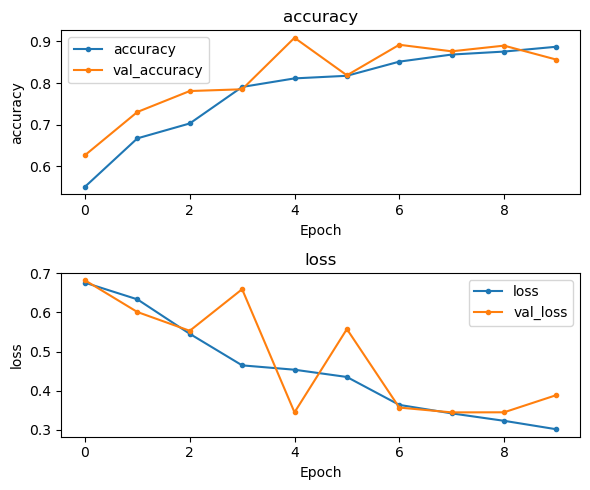

In [114]:
# Build the lstm model and specify the vectorizer
gru_glove_model = build_gru_model_glove(sequence_vectorizer, embedding_matrix)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = gru_glove_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
fn.plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       559
           1       0.90      0.89      0.89       559

    accuracy                           0.90      1118
   macro avg       0.90      0.90      0.90      1118
weighted avg       0.90      0.90      0.90      1118



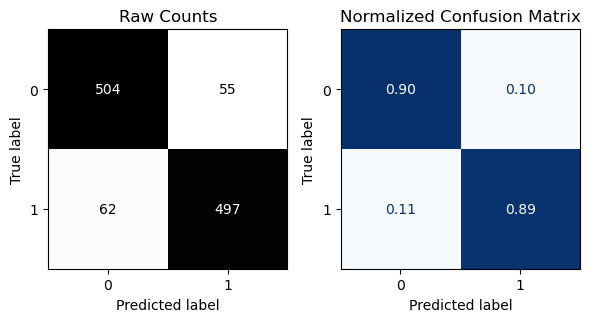


- Evaluating Training Data:
35/35 [==============================] - 0s 8ms/step - loss: 0.2806 - accuracy: 0.8953
{'loss': 0.28060704469680786, 'accuracy': 0.895348846912384}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       833
           1       0.44      0.89      0.59       121

    accuracy                           0.84       954
   macro avg       0.71      0.86      0.74       954
weighted avg       0.91      0.84      0.86       954



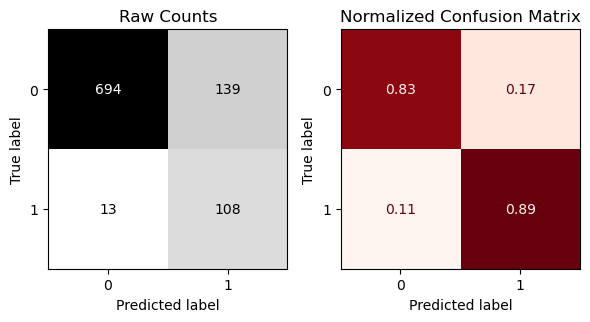


- Evaluating Test Data:
30/30 [==============================] - 0s 8ms/step - loss: 0.4110 - accuracy: 0.8407
{'loss': 0.411030650138855, 'accuracy': 0.8406708836555481}


In [115]:
# Obtain the results
results = fn.evaluate_classification_network(
    gru_glove_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

>The models performance did not increase dramatically. We prevented the model from updating the word embeddings from GloVe, but we can also allow then model to update them as it trains the model.

### Pretrained Embedding - Trainable=True

In [116]:
def build_gru_model_train_glove(text_vectorization_layer, embedding_matrix):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    # Create the embedding layer using the embedding matrix
    initializer = tf.keras.initializers.Constant(embedding_matrix)
    glove_embedding_layer = layers.Embedding(input_dim=VOCAB_SIZE,
                                output_dim=EMBED_DIM,
                                embeddings_initializer =initializer,
                                trainable=True,  # Update the embeddings 
                                input_length=SEQUENCE_LENGTH)

    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        glove_embedding_layer
        ])
        
    # Add *new* LSTM layer
    model.add(layers.GRU(32, recurrent_dropout=.2,dropout=.1, return_sequences=True))
    model.add(layers.GlobalAveragePooling1D())
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_15 (Embedding)    (None, 150, 100)          588900    
                                                                 
 gru_6 (GRU)                 (None, 150, 32)           12864     
                                                                 
 global_average_pooling1d_8   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 601,797
Trainable params: 601,797
Non-t

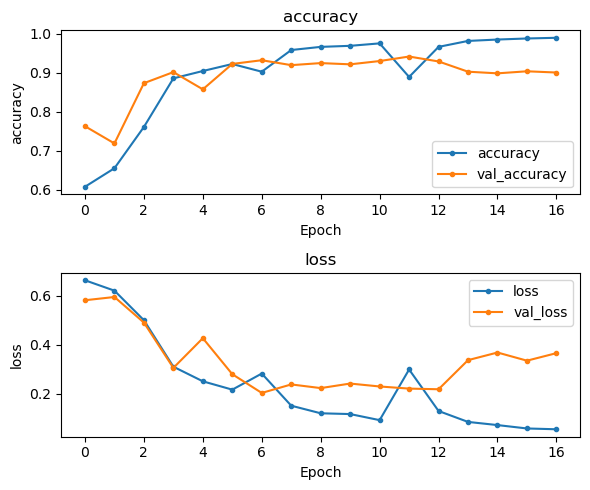

In [117]:
# Build the lstm model and specify the vectorizer
gru_glove_model = build_gru_model_train_glove(sequence_vectorizer, embedding_matrix)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = gru_glove_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
fn.plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       559
           1       0.99      0.99      0.99       559

    accuracy                           0.99      1118
   macro avg       0.99      0.99      0.99      1118
weighted avg       0.99      0.99      0.99      1118



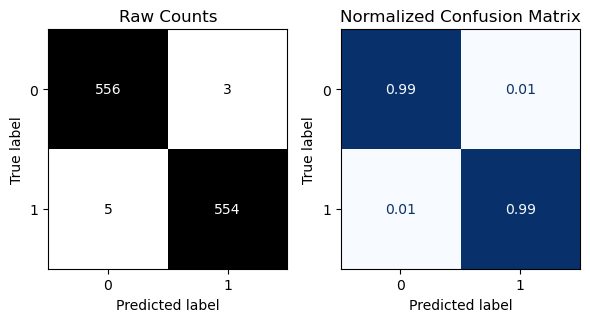


- Evaluating Training Data:
35/35 [==============================] - 0s 8ms/step - loss: 0.0381 - accuracy: 0.9928
{'loss': 0.038118381053209305, 'accuracy': 0.9928443431854248}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       833
           1       0.55      0.97      0.70       121

    accuracy                           0.90       954
   macro avg       0.77      0.93      0.82       954
weighted avg       0.94      0.90      0.91       954



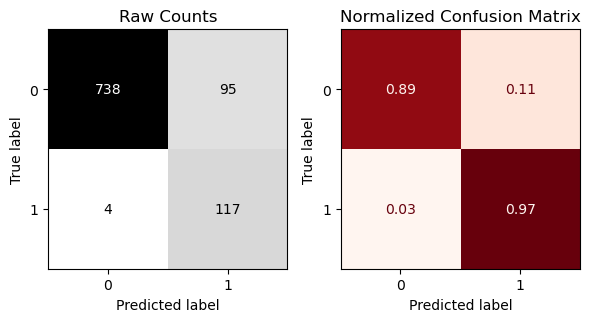


- Evaluating Test Data:
30/30 [==============================] - 0s 8ms/step - loss: 0.3928 - accuracy: 0.8962
{'loss': 0.39279523491859436, 'accuracy': 0.8962264060974121}


In [118]:
# Obtain the results
results = fn.evaluate_classification_network(
    gru_glove_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

# APPENDIX

## (Bonus/If There's Time) Learning Rate Scheduling

One tactic we can also attempt is to use a Learning Rate schdule to reduce the learning rate as the model fits. Allowing for increased learning in the early epochs, and then slowing down the learning rate.

In [129]:
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

In [145]:
def build_gru_model_glove(text_vectorization_layer, embedding_matrix):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    # Create the embedding layer using the embedding matrix
    initializer = tf.keras.initializers.Constant(embedding_matrix)
    glove_embedding_layer = layers.Embedding(input_dim=VOCAB_SIZE,
                                output_dim=EMBED_DIM,
                                embeddings_initializer =initializer,
                                trainable=False,  # Keeps the embeddings fixed
                                input_length=SEQUENCE_LENGTH)

    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        glove_embedding_layer
        ])
        
    # Add *new* LSTM layer
    model.add(layers.GRU(32, recurrent_dropout=.1,dropout=.1, return_sequences=True))
    model.add(layers.GlobalAveragePooling1D())
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=10000,
        decay_rate=0.9)
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = lr_schedule), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model

# def get_callbacks(patience=3, monitor='val_accuracy'):
#     early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
#     return [early_stop]

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_24 (Embedding)    (None, 150, 100)          588900    
                                                                 
 gru_15 (GRU)                (None, 150, 32)           12864     
                                                                 
 global_average_pooling1d_15  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 601,797
Trainable params: 12,897
Non-tr

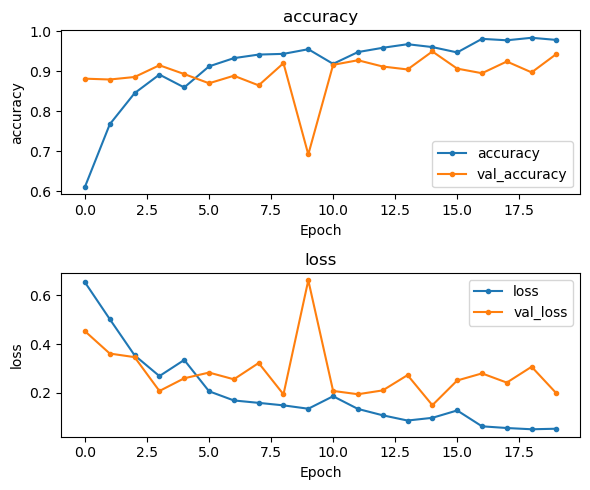

In [146]:
# Build the lstm model and specify the vectorizer
gru_glove_model = build_gru_model_glove(sequence_vectorizer, embedding_matrix)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = gru_glove_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
fn.plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       559
           1       1.00      0.99      0.99       559

    accuracy                           0.99      1118
   macro avg       0.99      0.99      0.99      1118
weighted avg       0.99      0.99      0.99      1118



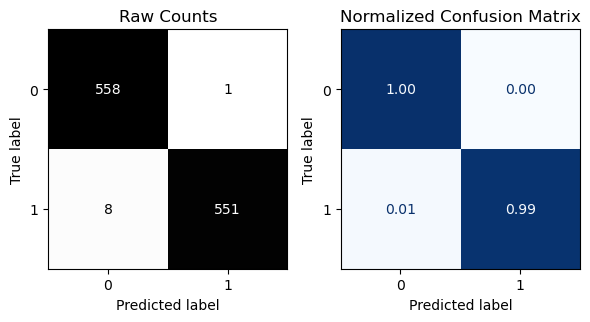


- Evaluating Training Data:
35/35 [==============================] - 0s 8ms/step - loss: 0.0201 - accuracy: 0.9919
{'loss': 0.02010093256831169, 'accuracy': 0.9919499158859253}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       833
           1       0.65      0.84      0.73       121

    accuracy                           0.92       954
   macro avg       0.81      0.89      0.84       954
weighted avg       0.93      0.92      0.93       954



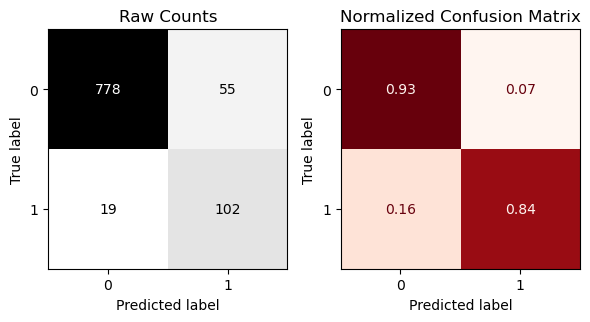


- Evaluating Test Data:
30/30 [==============================] - 0s 8ms/step - loss: 0.2876 - accuracy: 0.9224
{'loss': 0.28758153319358826, 'accuracy': 0.9224318861961365}


In [147]:
# Obtain the results
results = fn.evaluate_classification_network(
    gru_glove_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

> Learning rate scheduling can be a powerful tool that can be combined with all/any of the other methods we've shown.

## Alternative Text Preprocessing Options

Everything we have tuned/tested thus far has been related to the model itself. There are still several aspects of the text vectorization that we could also try:
- embedding dimension
- normalization
- sequence length
- ngrams

## Summary

- There are many tactics that we can leverage when working with Sequence models.  Ultimately, the best params will vary with the dataset and the text preprocessing options.
- We can also tune all of the standard parameters from previous lessons on Deep learning (e.g. number of units, activation function,etc.)